In [ ]:
!pip install git+https://github.com/sebastian-sz/efficientnet-v2-keras@main

In [29]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import cv2

import efficientnet
import efficientnet.tfkeras as efn
from efficientnet_v2 import EfficientNetV2L, EfficientNetV2S, EfficientNetV2B0

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow.keras as keras
from tensorflow.data import Dataset

import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings(action='ignore')

In [14]:
def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    for case_name in os.listdir(data_dir):
        current_path = os.path.join(data_dir, case_name)
        if os.path.isdir(current_path):
            # get image path
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.jpg')))
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.png')))
            
            # get label
            label_df =pd.read_csv(current_path+'/label-{}.csv'.format(int(case_name[-2:])))
            label_list.extend(label_df['leaf_weight'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    # get image path
    img_path_list = glob(os.path.join(data_dir, 'image', '*.jpg'))
    img_path_list.extend(glob(os.path.join(data_dir, 'image', '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
    return img_path_list

def load_img_numpy(img_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = (img.astype(np.float32) - 128.0 ) / 128.0
    return img

def create_dataset(img_dir, label, target_size, batch_size=None) :    
    img = [] # 원본이미지
    
    ## 최적화가 필요한 부분
    for i in img_dir:
        image = load_img_numpy(i, target_size)
        img.append(image)
        
    x = Dataset.from_tensor_slices(img)
    y = Dataset.from_tensor_slices(label)
    dataset = Dataset.zip((x, y))
    
    if batch_size is not None:
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
   
    return dataset

def load_test_img_numpy(img_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = (img.astype(np.float32) - 128.0 ) / 128.0
    return img

def create_test_dataset(img_dir, target_size, batch_size=None) :
    file_name = [x.split('/')[-1][:-4] for x in img_dir]
    x_img = []

    for i in tqdm(img_dir,
                total=len(img_dir),
                position=0,
                leave=True):
        img = load_test_img_numpy(i, target_size)
        x_img.append(img)

    dataset = Dataset.from_tensor_slices(x_img)
    
    if batch_size is not None :
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
       
    return dataset, file_name

In [15]:
IMAGE_SIZE = 480
BATCH_SIZE = 8

all_img_path, all_label = get_train_data('./data/train')
test_img_path = get_test_data('./data/test')

In [16]:
# Train : Validation = 0.8 : 0.2 Split
train_len = int(len(all_img_path)*0.8)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

vali_img_path = all_img_path[train_len:]
vali_label = all_label[train_len:]

In [17]:
train_dataset = create_dataset(train_img_path, train_label, (IMAGE_SIZE, IMAGE_SIZE), BATCH_SIZE)
valid_dataset = create_dataset(vali_img_path, vali_label, (IMAGE_SIZE, IMAGE_SIZE), BATCH_SIZE )

2022-05-11 15:49:45.681305: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3519590400 exceeds 10% of free system memory.
2022-05-11 15:56:46.913169: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 881971200 exceeds 10% of free system memory.


# EfficientNet V2 L

- https://www.wenyanet.com/opensource/ko/62386272dc72912a2b5ca0f2.html

In [5]:
LEARNING_RATE = 1e-4

In [18]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
input_data = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical')(input_data)
output_data = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
preprocess = Model(inputs=input_data, outputs=output_data)

In [7]:
base_model = EfficientNetV2L(
    weights='imagenet',
    include_top = False,
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
)
base_model.trainable = False

473276416/473268248 [==============================] - 62s 0us/step


In [22]:
base_model.summary() # train prams => 0

Model: "efficientnetv2-l"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 480, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 240, 240, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 240, 240, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 240, 240, 32) 0           stem_bn[0][0]                    
___________________________________________________________________________________

__________________________________________________________________________________________________
block6-24_expand_conv (Conv2D)  (None, 15, 15, 2304) 884736      block6-23_add[0][0]              
__________________________________________________________________________________________________
block6-24_expand_bn (BatchNorma (None, 15, 15, 2304) 9216        block6-24_expand_conv[0][0]      
__________________________________________________________________________________________________
block6-24_expand_activation (Ac (None, 15, 15, 2304) 0           block6-24_expand_bn[0][0]        
__________________________________________________________________________________________________
block6-24_dwconv2 (DepthwiseCon (None, 15, 15, 2304) 20736       block6-24_expand_activation[0][0]
__________________________________________________________________________________________________
block6-24_bn (BatchNormalizatio (None, 15, 15, 2304) 9216        block6-24_dwconv2[0][0]          
__________

In [20]:
model = Sequential()
model.add(preprocess)
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 480, 480, 3)       0         
_________________________________________________________________
efficientnetv2-l (Functional (None, 15, 15, 1280)      117746848 
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 117,828,897
Trainable params: 82,049
Non-trainable params: 117,746,848
_________________________________________________________________


In [23]:
checkpoint_filepath = './Model_Save/eff_v2_L/effL.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

2022-05-11 16:01:37.757284: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3519590400 exceeds 10% of free system memory.


Epoch 1/30


2022-05-11 16:01:52.028673: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-11 16:01:52.169994: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499990000 Hz
2022-05-11 16:01:55.066427: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-11 16:01:55.275706: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


159/159 [==============================] - ETA: 0s - loss: 82.4254 - mae: 82.4254

2022-05-11 16:03:04.323799: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 881971200 exceeds 10% of free system memory.


159/159 [==============================] - 105s 553ms/step - loss: 82.3984 - mae: 82.3984 - val_loss: 75.7157 - val_mae: 75.7157

Epoch 00001: val_mae improved from inf to 75.71574, saving model to ./Model_Save/eff_v2_L/effL.ckpt
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 78.3709 - mae: 78.3709

2022-05-11 16:04:34.720498: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 881971200 exceeds 10% of free system memory.


159/159 [==============================] - 85s 533ms/step - loss: 78.3494 - mae: 78.3494 - val_loss: 73.6940 - val_mae: 73.6940

Epoch 00002: val_mae improved from 75.71574 to 73.69398, saving model to ./Model_Save/eff_v2_L/effL.ckpt
Epoch 3/30
159/159 [==============================] - 83s 519ms/step - loss: 76.5090 - mae: 76.5090 - val_loss: 72.4057 - val_mae: 72.4057

Epoch 00003: val_mae improved from 73.69398 to 72.40572, saving model to ./Model_Save/eff_v2_L/effL.ckpt
Epoch 4/30
159/159 [==============================] - 81s 512ms/step - loss: 74.9797 - mae: 74.9797 - val_loss: 71.5848 - val_mae: 71.5848

Epoch 00004: val_mae improved from 72.40572 to 71.58484, saving model to ./Model_Save/eff_v2_L/effL.ckpt
Epoch 5/30
159/159 [==============================] - 82s 513ms/step - loss: 74.1334 - mae: 74.1334 - val_loss: 70.9853 - val_mae: 70.9853

Epoch 00005: val_mae improved from 71.58484 to 70.98532, saving model to ./Model_Save/eff_v2_L/effL.ckpt
Epoch 6/30
159/159 [===========

Text(0.5, 1.0, 'Training and Validation MAE')

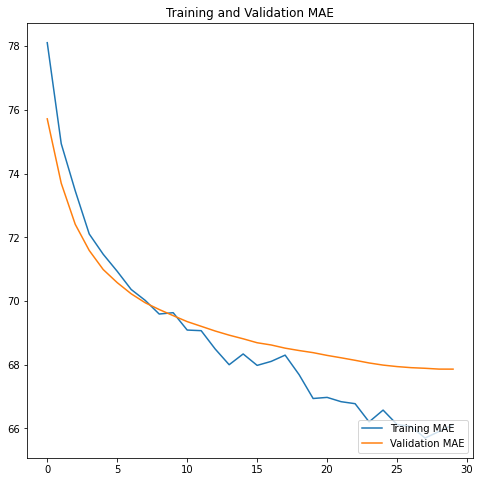

In [24]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

In [25]:
model.save('./Model_Save/eff_v2_L.h5')

# EfficientNet V2 S

In [31]:
MODEL_IMAGE_SIZE = 384

In [41]:
input_data_s = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data_s)
x = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical')(x)
output_data_s = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
augmentation = Model(inputs=input_data_s, outputs=output_data_s)

In [32]:
base_model_s = EfficientNetV2S(
    weights='imagenet',
    include_top = False,
    input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE, 3)
)
base_model_s.trainable = False

82468864/82461840 [==============================] - 3s 0us/step


In [42]:
model_s = Sequential()
model_s.add(augmentation)
model_s.add(base_model_s)
model_s.add(GlobalAveragePooling2D())
model_s.add(Dense(64, activation='relu'))
model_s.add(Dense(1, activation='linear'))

model_s.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

In [43]:
model_s.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 384, 384, 3)       0         
_________________________________________________________________
efficientnetv2-s (Functional (None, 12, 12, 1280)      20331360  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                81984     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 20,413,409
Trainable params: 82,049
Non-trainable params: 20,331,360
_________________________________________________________________


In [44]:
checkpoint_filepath = './Model_Save/eff_v2_S/effL.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history_s = model_s.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - 29s 132ms/step - loss: 82.5213 - mae: 82.5213 - val_loss: 75.6424 - val_mae: 75.6424

Epoch 00001: val_mae improved from inf to 75.64243, saving model to ./Model_Save/eff_v2_S/effL.ckpt
Epoch 2/30
159/159 [==============================] - 19s 118ms/step - loss: 77.8330 - mae: 77.8330 - val_loss: 73.2040 - val_mae: 73.2040

Epoch 00002: val_mae improved from 75.64243 to 73.20404, saving model to ./Model_Save/eff_v2_S/effL.ckpt
Epoch 3/30
159/159 [==============================] - 19s 119ms/step - loss: 75.7980 - mae: 75.7980 - val_loss: 71.7527 - val_mae: 71.7527

Epoch 00003: val_mae improved from 73.20404 to 71.75274, saving model to ./Model_Save/eff_v2_S/effL.ckpt
Epoch 4/30
159/159 [==============================] - 19s 120ms/step - loss: 74.1559 - mae: 74.1559 - val_loss: 70.6993 - val_mae: 70.6993

Epoch 00004: val_mae improved from 71.75274 to 70.69933, saving model to ./Model_Save/eff_v2_S/effL.ckpt
Epoch 5/30
159/159 [=====

Text(0.5, 1.0, 'Training and Validation MAE')

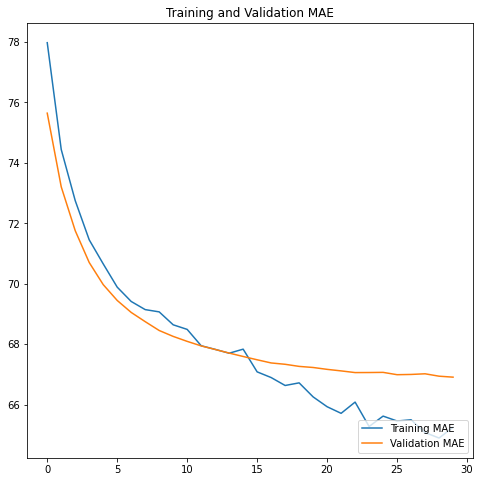

In [46]:
plt.figure(figsize=(8, 8))
plt.plot(history_s.history['mae'], label='Training MAE')
plt.plot(history_s.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

Epoch 1/30
159/159 [==============================] - 28s 131ms/step - loss: 18331.2021 - mae: 82.3811 - val_loss: 15881.2168 - val_mae: 75.0894
Epoch 2/30
159/159 [==============================] - 19s 118ms/step - loss: 16598.1496 - mae: 76.9909 - val_loss: 14616.1104 - val_mae: 71.7975
Epoch 3/30
159/159 [==============================] - 19s 117ms/step - loss: 15167.5380 - mae: 74.3519 - val_loss: 13471.3477 - val_mae: 69.6979
Epoch 4/30
159/159 [==============================] - 19s 119ms/step - loss: 13768.8151 - mae: 72.3080 - val_loss: 12590.7891 - val_mae: 68.9295
Epoch 5/30
159/159 [==============================] - 19s 118ms/step - loss: 12838.7717 - mae: 72.3588 - val_loss: 11932.1748 - val_mae: 68.9996
Epoch 6/30
159/159 [==============================] - 19s 118ms/step - loss: 12170.6756 - mae: 73.2176 - val_loss: 11452.8018 - val_mae: 69.4607
Epoch 7/30
159/159 [==============================] - 19s 118ms/step - loss: 11604.5443 - mae: 73.9206 - val_loss: 11140.3018 - va

Text(0.5, 1.0, 'Training and Validation MAE')

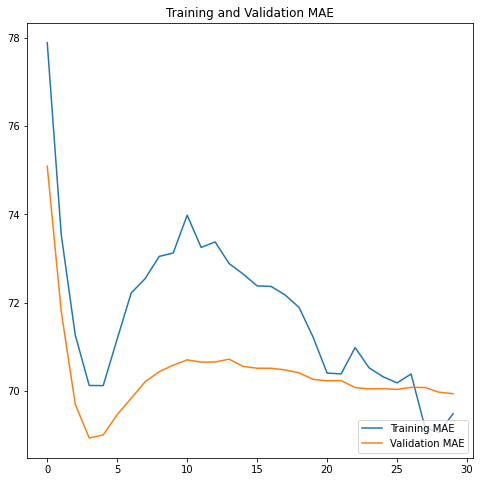

In [47]:
# loss function = mse로

base_model_s = EfficientNetV2S(
    weights='imagenet',
    include_top = False,
    input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE, 3)
)
base_model_s.trainable = False

model_s = Sequential()
model_s.add(augmentation)
model_s.add(base_model_s)
model_s.add(GlobalAveragePooling2D())
model_s.add(Dense(64, activation='relu'))
model_s.add(Dense(1, activation='linear'))

model_s.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mse',
              metrics=['mae'])

EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history_s = model_s.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    #callbacks=[checkpointer],
                    verbose=1)

plt.figure(figsize=(8, 8))
plt.plot(history_s.history['mae'], label='Training MAE')
plt.plot(history_s.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

Text(0.5, 1.0, 'Training and Validation MAE')

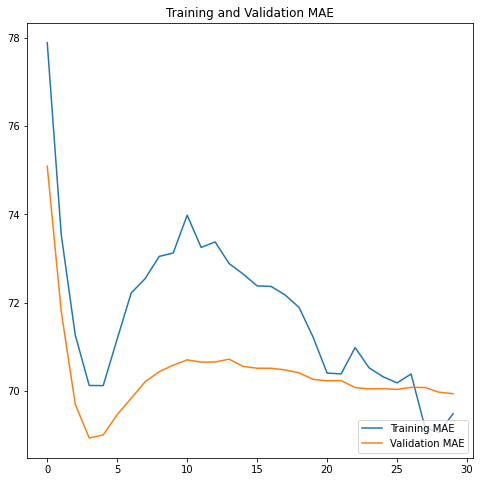

In [48]:
plt.figure(figsize=(8, 8))
plt.plot(history_s.history['mae'], label='Training MAE')
plt.plot(history_s.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

# EfficientNet V2 B0

In [49]:
MODEL_IMAGE_SIZE = 224

In [50]:
base_model_0 = EfficientNetV2B0(
    weights='imagenet',
    include_top = False,
    input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE, 3)
)


24289280/24286736 [==============================] - 1s 0us/step


In [51]:
input_data_0 = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data_0)
x = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical')(x)
output_data_0 = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
augmentation = Model(inputs=input_data_0, outputs=output_data_0)

In [54]:
base_model_0.trainable = False

model_0 = Sequential()
model_0.add(augmentation)
model_0.add(base_model_0)
model_0.add(GlobalAveragePooling2D())
model_0.add(Dense(64, activation='relu'))
model_0.add(Dense(1, activation='linear'))

model_0.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

In [55]:
EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history_0 = model_0.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    # callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - 11s 41ms/step - loss: 82.4614 - mae: 82.4614 - val_loss: 75.9810 - val_mae: 75.9810
Epoch 2/30
159/159 [==============================] - 5s 34ms/step - loss: 78.1032 - mae: 78.1032 - val_loss: 73.6854 - val_mae: 73.6854
Epoch 3/30
159/159 [==============================] - 5s 34ms/step - loss: 75.9844 - mae: 75.9844 - val_loss: 72.4603 - val_mae: 72.4603
Epoch 4/30
159/159 [==============================] - 5s 34ms/step - loss: 74.6632 - mae: 74.6632 - val_loss: 71.5233 - val_mae: 71.5233
Epoch 5/30
159/159 [==============================] - 5s 34ms/step - loss: 73.7699 - mae: 73.7699 - val_loss: 70.9009 - val_mae: 70.9009
Epoch 6/30
159/159 [==============================] - 5s 34ms/step - loss: 73.1335 - mae: 73.1335 - val_loss: 70.4486 - val_mae: 70.4486
Epoch 7/30
159/159 [==============================] - 5s 34ms/step - loss: 72.7175 - mae: 72.7175 - val_loss: 70.0980 - val_mae: 70.0980
Epoch 8/30
159/159 [====================

Text(0.5, 1.0, 'Training and Validation MAE')

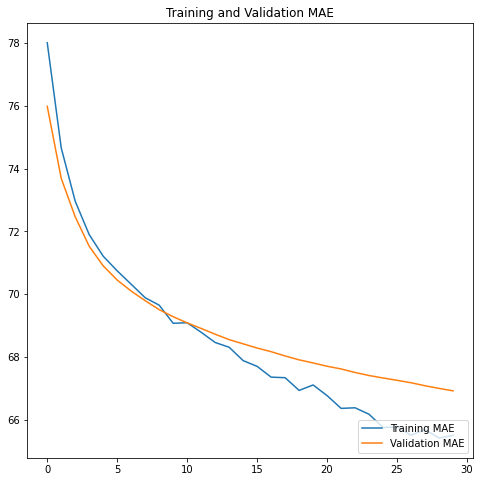

In [56]:
plt.figure(figsize=(8, 8))
plt.plot(history_0.history['mae'], label='Training MAE')
plt.plot(history_0.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

In [58]:
mae = history_0.history['mae']
val_mae = history_0.history['val_mae']


history_0 = model_0.fit(train_dataset, epochs=70,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    # callbacks=[checkpointer],
                    verbose=1)

Epoch 1/70
159/159 [==============================] - 6s 35ms/step - loss: 65.0731 - mae: 65.0731 - val_loss: 66.8561 - val_mae: 66.8561
Epoch 2/70
159/159 [==============================] - 5s 34ms/step - loss: 65.2989 - mae: 65.2989 - val_loss: 66.7684 - val_mae: 66.7684
Epoch 3/70
159/159 [==============================] - 5s 34ms/step - loss: 65.1577 - mae: 65.1577 - val_loss: 66.7004 - val_mae: 66.7004
Epoch 4/70
159/159 [==============================] - 5s 34ms/step - loss: 64.8200 - mae: 64.8200 - val_loss: 66.6644 - val_mae: 66.6644
Epoch 5/70
159/159 [==============================] - 5s 34ms/step - loss: 64.9325 - mae: 64.9325 - val_loss: 66.6597 - val_mae: 66.6597
Epoch 6/70
159/159 [==============================] - 5s 33ms/step - loss: 64.4639 - mae: 64.4639 - val_loss: 66.6224 - val_mae: 66.6224
Epoch 7/70
159/159 [==============================] - 5s 33ms/step - loss: 64.7798 - mae: 64.7798 - val_loss: 66.5906 - val_mae: 66.5906
Epoch 8/70
159/159 [=====================

159/159 [==============================] - 5s 34ms/step - loss: 61.7018 - mae: 61.7018 - val_loss: 65.8045 - val_mae: 65.8045
Epoch 61/70
159/159 [==============================] - 6s 35ms/step - loss: 61.4455 - mae: 61.4455 - val_loss: 65.7753 - val_mae: 65.7753
Epoch 62/70
159/159 [==============================] - 6s 35ms/step - loss: 61.2086 - mae: 61.2086 - val_loss: 65.7489 - val_mae: 65.7489
Epoch 63/70
159/159 [==============================] - 6s 35ms/step - loss: 61.4753 - mae: 61.4753 - val_loss: 65.7526 - val_mae: 65.7526
Epoch 64/70
159/159 [==============================] - 5s 34ms/step - loss: 61.6810 - mae: 61.6810 - val_loss: 65.7439 - val_mae: 65.7439
Epoch 65/70
159/159 [==============================] - 5s 34ms/step - loss: 61.1288 - mae: 61.1288 - val_loss: 65.7747 - val_mae: 65.7747
Epoch 66/70
159/159 [==============================] - 5s 35ms/step - loss: 61.3926 - mae: 61.3926 - val_loss: 65.7896 - val_mae: 65.7896
Epoch 67/70
159/159 [=========================

Text(0.5, 1.0, 'Training and Validation MAE')

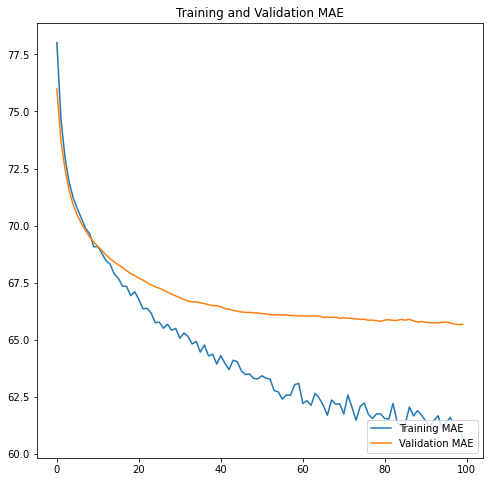

In [59]:
mae += history_0.history['mae']
val_mae += history_0.history['val_mae']



plt.figure(figsize=(8, 8))
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

## Fine Tune

In [60]:
base_model_0.trainable=False
print("Number of layers in the base model: ", len(base_model_0.layers))

Number of layers in the base model:  268


In [62]:
base_model_0.trainable = True
fine_tune_at = int(len(base_model_0.layers) * 0.9)
print(fine_tune_at)

241


In [63]:
# 동결 해제
fine_tune_at = int(len(base_model_0.layers) * 0.9)
for i, layer in enumerate(base_model_0.layers) :
    if i < fine_tune_at :
        layer.trainable = False
    else :
           if 'bn' in layer.name :
                layer.trainable = False

In [64]:
model_0.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Functional)         (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetv2-b0 (Functiona (None, 7, 7, 1280)        5919312   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                81984     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 6,001,361
Trainable params: 1,225,313
Non-trainable params: 4,776,048
_________________________________________________________________


In [65]:
model_0.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10),
              loss='mae',
              metrics=['mae'])

In [66]:
EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history_fine = model_0.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)


Epoch 1/30
159/159 [==============================] - 11s 45ms/step - loss: 60.8830 - mae: 60.8830 - val_loss: 65.7133 - val_mae: 65.7133

Epoch 00001: val_mae improved from 66.90588 to 65.71329, saving model to ./Model_Save/eff_v2_S/effL.ckpt
Epoch 2/30
159/159 [==============================] - 6s 37ms/step - loss: 60.7763 - mae: 60.7763 - val_loss: 65.7677 - val_mae: 65.7677

Epoch 00002: val_mae did not improve from 65.71329
Epoch 3/30
159/159 [==============================] - 6s 37ms/step - loss: 59.8612 - mae: 59.8612 - val_loss: 65.9660 - val_mae: 65.9660

Epoch 00003: val_mae did not improve from 65.71329
Epoch 4/30
159/159 [==============================] - 6s 37ms/step - loss: 60.1751 - mae: 60.1751 - val_loss: 65.8780 - val_mae: 65.8780

Epoch 00004: val_mae did not improve from 65.71329
Epoch 5/30
159/159 [==============================] - 6s 36ms/step - loss: 59.4502 - mae: 59.4502 - val_loss: 65.8352 - val_mae: 65.8352

Epoch 00005: val_mae did not improve from 65.71329


Text(0.5, 1.0, 'Training and Validation MAE')

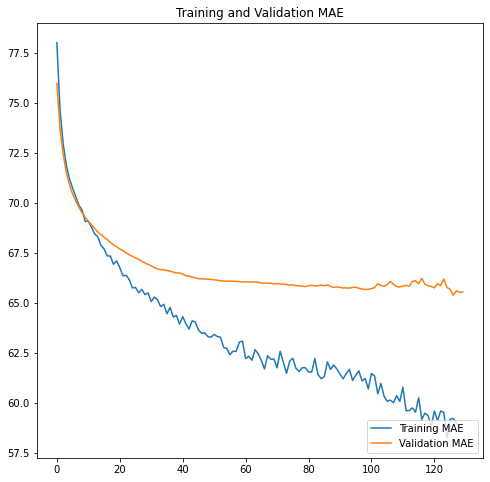

In [68]:
mae += history_fine.history['mae']
val_mae += history_fine.history['val_mae']

plt.figure(figsize=(8, 8))
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

### Prediction

In [ ]:
PRED_BATCH_SIZE = 10
test_dataset, file_names = create_test_dataset(test_img_path, (IMAGE_SIZE, IMAGE_SIZE), PRED_BATCH_SIZE )

In [ ]:
STEPS = len(test_img_path) / PRED_BATCH_SIZE
prediction = model.predict(test_dataset,
                            batch_size = PRED_BATCH_SIZE,
                            steps=STEPS)

In [ ]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['leaf_weight'] = prediction.squeeze()
submission.to_csv('./data/effecientnet_cnn.csv', index=False)